In [1]:
import pickle
import random
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

import _config as cfg
import DataSets_validation as ds
import kaplanmeier as km
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearnex import patch_sklearn

patch_sklearn()

from sklearn import svm
from sklearn.metrics import (accuracy_score, auc, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from tqdm.notebook import tqdm

yeloh_seed = 2137

random.seed(1024)
np.random.seed(1024)

results_dir = Path("Results")
results_dir.mkdir(parents=True, exist_ok=True)

# Matplotlib config
plt.rcdefaults()

main_font_size = 7
label_font_size = 10

axis_color = "0.15"

plt.rcParams["text.color"] = axis_color
plt.rcParams["axes.labelcolor"] = axis_color
plt.rcParams["xtick.color"] = axis_color
plt.rcParams["ytick.color"] = axis_color
plt.rcParams["axes.edgecolor"] = axis_color

plt.rcParams["font.size"] = main_font_size
plt.rcParams["axes.labelsize"] = main_font_size
plt.rcParams["axes.titlesize"] = main_font_size
plt.rcParams["xtick.labelsize"] = main_font_size
plt.rcParams["ytick.labelsize"] = main_font_size
plt.rcParams["legend.fontsize"] = main_font_size
plt.rcParams["figure.labelsize"] = main_font_size
plt.rcParams["figure.titlesize"] = main_font_size

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["savefig.transparent"] = True

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"


def figsize_in_mm(width, height):
    mm = 1 / 25.4  # millimeters in inches
    return (width * mm, height * mm)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def svm_train_test(train_data, train_y, test_data, verbose=False, clf_kwargs={}):
    sm = SMOTE(random_state=432)
    train_data, train_y = sm.fit_resample(train_data, train_y)
    clf = svm.SVC(probability=True, random_state=yeloh_seed, **clf_kwargs)
    clf = clf.fit(train_data, train_y)

    predictions = clf.predict(test_data)
    probs = clf.predict_proba(test_data)
    probSV = [i[1] for i in probs]
    if verbose:
        print(probSV)
    new_pd = pd.DataFrame(probSV)
    return clf, predictions, new_pd

  0%|          | 0/4 [00:00<?, ?it/s]

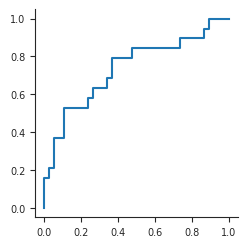

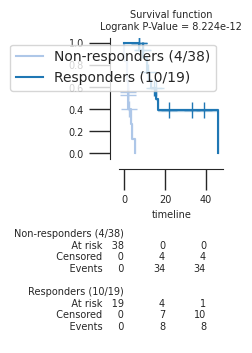

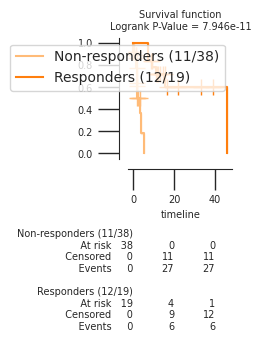

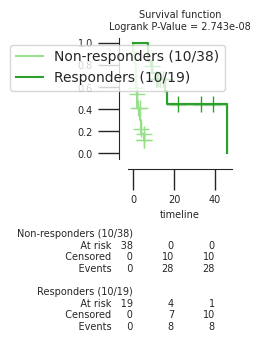

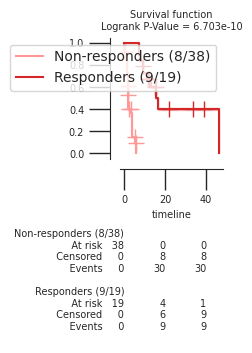

Baseline:
  Accuracy: 0.772
  Precision: 0.714
  Recall: 0.526
  F1 Score: 0.606
  ROC AUC: 0.734
    _MEAN_: 0.671
Peptide level:
  Accuracy: 0.684
  Precision: 0.522
  Recall: 0.632
  F1 Score: 0.571
  ROC AUC: 0.698
    _MEAN_: 0.621
Contig level:
  Accuracy: 0.667
  Precision: 0.500
  Recall: 0.526
  F1 Score: 0.513
  ROC AUC: 0.647
    _MEAN_: 0.571
Scaffold level:
  Accuracy: 0.684
  Precision: 0.529
  Recall: 0.474
  F1 Score: 0.500
  ROC AUC: 0.639
    _MEAN_: 0.565



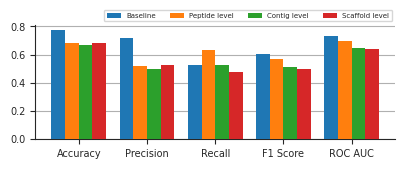

In [3]:
# Config

# Figures config
legend_font_size = 5
text_font_size = 5

fig_roc_size = figsize_in_mm(60, 60)

fig_surv_size = figsize_in_mm(34, 40)

fig_sc_size = figsize_in_mm(100, 40)
fig_sc_bar_width = 0.2

#

mut_vec_len_label = "mut_vec_len"
clf_params_label = "clf_params"
model_name_label = "plot_label"

m_num = len(cfg.configurations)

model_colors = {n[model_name_label]: f"C{i}" for i, n in enumerate(cfg.configurations)}
model_colors_surv_lines = {}
i = 0
for n in cfg.configurations:
    lines_c = [plt.color_sequences["tab20"][i + 1], plt.color_sequences["tab20"][i]]
    model_colors_surv_lines[n[model_name_label]] = lines_c
    i += 2

fig_roc = plt.figure(figsize=fig_roc_size, layout="constrained")
ax_roc = fig_roc.add_subplot()

test_scores_str = ""
test_scores_names = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
test_scores = {}

surv_ylabel = True

for config in tqdm(cfg.configurations, leave=False):
    dimension_of_embedding_vectors = config[mut_vec_len_label]
    clf_params = config[clf_params_label]
    model_name = config[model_name_label]

    train_data, train_y, test_data, test_y, test_pfs, _ = ds.transforming_Braun_dataset(
        config, dimension_of_embedding_vectors
    )

    model, svm_linear_preds, svm_prob = svm_train_test(
        train_data, train_y, test_data, clf_kwargs=clf_params
    )

    probs = svm_prob.values.flatten()
    fpr, tpr, _ = roc_curve(test_y, probs)
    roc_auc = auc(fpr, tpr)

    prec = precision_score(test_y, svm_linear_preds)
    rec = recall_score(test_y, svm_linear_preds)
    f1 = f1_score(test_y, svm_linear_preds)
    acc = accuracy_score(test_y, svm_linear_preds)
    rauc = roc_auc_score(test_y, probs)

    test_scores_str += f"{model_name}:\n"
    test_scores_str += f"  {test_scores_names[0]}: {acc:.3f}\n"
    test_scores_str += f"  {test_scores_names[1]}: {prec:.3f}\n"
    test_scores_str += f"  {test_scores_names[2]}: {rec:.3f}\n"
    test_scores_str += f"  {test_scores_names[3]}: {f1:.3f}\n"
    test_scores_str += f"  {test_scores_names[4]}: {rauc:.3f}\n"
    test_scores_str += f"    _MEAN_: {(acc+prec+rec+f1+rauc)/5:.3f}\n"

    test_scores[model_name] = {}
    test_scores[model_name][test_scores_names[0]] = acc
    test_scores[model_name][test_scores_names[1]] = prec
    test_scores[model_name][test_scores_names[2]] = rec
    test_scores[model_name][test_scores_names[3]] = f1
    test_scores[model_name][test_scores_names[4]] = rauc

    _ = ax_roc.plot(
        fpr,
        tpr,
        label=f"{model_name} (AUC={roc_auc:.3f})",
        color=model_colors[model_name],
    )

    with open(
        results_dir.joinpath(f"svm-model-{model_name.replace(' ', '_')}.pkl"),
        "wb",
    ) as f:
        pickle.dump(model, f)

    # Response prediction
    time_event = test_pfs.reset_index(drop=True)
    censoring = pd.Series([1 if p == -1 else 0 for p in svm_linear_preds])
    labx = pd.Series(["Responders" if y == 1 else "Non-responders" for y in test_y])
    surv_pred = km.fit(time_event, censoring, labx)
    logrank_p = surv_pred["logrank_P"]
    fig_surv, ax_surv = km.plot(
        surv_pred,
        figsize=fig_surv_size,
        fontsize=main_font_size,
        cmap=model_colors_surv_lines[model_name],
    )
    # old_title = ax_surv.get_title()
    # p_value_str = old_title.replace("Survival function\n", "")
    ax_surv.set_title(None)
    ax_surv.text(
        0.85,
        0.1,
        f"Logrank P-value:\n{logrank_p:.3e}",
        ha="right",
        va="bottom",
        transform=ax_surv.transAxes,
        fontsize=text_font_size,
    )
    # ax_surv.set_title(
    #     old_title.replace("Survival function", f"{model_name}"),
    #     {"fontsize": label_font_size},
    # )
    ax_surv.tick_params(length=3.5)
    ax_surv.set_xlabel("Time (months)")
    if surv_ylabel:
        ax_surv.set_ylabel("Probability of response")
        surv_ylabel = False
    ax_surv.legend(
        handlelength=0.8,
        handletextpad=0.5,
        labelspacing=0.8,
        fontsize=legend_font_size,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.4),
    )
    for fmt in ["pdf", "png"]:
        fig_surv.savefig(
            results_dir.joinpath(
                f"response-prediction-{model_name.replace(' ', '_')}.{fmt}"
            ),
            bbox_inches="tight",
            pad_inches=0.03,
            dpi=600,
        )

# ROC
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
# ax_roc.set_title("ROC Curves for different levels", {"fontsize": label_font_size})
ax_roc.legend(loc="lower right", fontsize=legend_font_size)
for fmt in ["pdf", "png"]:
    fig_roc.savefig(results_dir.joinpath(f"roc-curves.{fmt}"), dpi=600)

print(test_scores_str)

# Scores
m_names = list(test_scores.keys())
s_num = len(test_scores_names)
x = np.arange(s_num)
b_pos = np.arange(
    fig_sc_bar_width / 2 * (1 - m_num),
    fig_sc_bar_width / 2 * (m_num - 1),
    fig_sc_bar_width,
)
fig_sc = plt.figure(figsize=fig_sc_size, layout="constrained")
ax_sc = fig_sc.add_subplot()
for n, p in zip(m_names, b_pos):
    _ = ax_sc.bar(
        x + p,
        list(test_scores[n].values()),
        width=fig_sc_bar_width,
        label=n,
        color=model_colors[n],
        zorder=10,
    )
ax_sc.set_xticks(x, test_scores_names)
ax_sc.grid(axis="y")
_ = ax_sc.legend(
    fontsize=legend_font_size, ncols=m_num, loc="lower right", bbox_to_anchor=(1, 1)
)
for fmt in ["pdf", "png"]:
    fig_sc.savefig(results_dir.joinpath(f"scores.{fmt}"), dpi=600)